In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/face recognition/face recognition

/content/drive/My Drive/face recognition/face recognition


#**TRAIN AND TEST  AT&T DATASET USING SIAMESE NETWOEK**

###**LOAD DATA**

In [3]:
#import libraries
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageOps  

import torch
from torch.autograd import Variable  
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils

from torch.utils.data import DataLoader, Dataset

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # converting to channel last notation
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class Config():
    training_dir = "./data/data_new/dataset_task2/training/"
    testing_dir = "./data/data_new/dataset_task2/testing/"
    unknown_dir = "./data/data_new/dataset_task2/unknown"
    train_batch_size = 64
    train_number_epochs = 30

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None, should_invert=True): #invoked when u create the object -> folder data set
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) # (imgdata, classname) img0_tuple[0] img0_tuple[1] ... s3
        #print("img0_tuple ", img0_tuple)
        
        #we need to make sure approx 50% of images are in the same class
        # you have to provide 50% same images and 50% different images
        should_get_same_class = random.randint(0,1) # tossing a coin -> same class or different class
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
        
        #print("img1_tuple ", img1_tuple)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        label = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        #print("label ", label)

        return img0, img1 , label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [9]:
folder_dataset.class_to_idx

{'Anuhya': 0,
 'aish': 1,
 's1': 2,
 's10': 3,
 's11': 4,
 's12': 5,
 's13': 6,
 's14': 7,
 's15': 8,
 's16': 9,
 's17': 10,
 's18': 11,
 's19': 12,
 's2': 13,
 's20': 14,
 's21': 15,
 's22': 16,
 's23': 17,
 's24': 18,
 's25': 19,
 's26': 20,
 's27': 21,
 's28': 22,
 's29': 23,
 's3': 24,
 's30': 25,
 's31': 26,
 's32': 27,
 's33': 28,
 's34': 29,
 's35': 30,
 's36': 31,
 's37': 32,
 's38': 33,
 's39': 34,
 's4': 35,
 's40': 36,
 's8': 37,
 's9': 38,
 'samreen': 39,
 'vijj': 40}

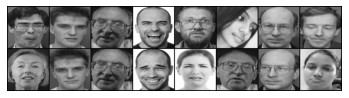

[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [10]:
#visualizing data
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

###**BUILD NETWORK**

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 128)) # 5 features, 128 features

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # flattening .. connect to fully connected layer
        output = self.fc1(output)
        return output

    def forward(self, input1, input2): # invoked automatically when you pass an image to object
        output1 = self.forward_once(input1)
        #capture those 128 features of image1
        output2 = self.forward_once(input2)
        #capture those 128 featues of image2
        return output1, output2
        
    def representations(self,inp):
        # to get the representations of train and test
        rep = self.forward_once(inp)
        return rep

In [12]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [19]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

###**TRAIN**

In [20]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [21]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 0.8593019843101501

Epoch number 1
 Current loss 10.857762336730957

Epoch number 2
 Current loss 6.704395771026611

Epoch number 3
 Current loss 18.029563903808594

Epoch number 4
 Current loss 4.13612174987793

Epoch number 5
 Current loss 6.043428897857666

Epoch number 6
 Current loss 9.210618019104004

Epoch number 7
 Current loss 0.9688345789909363

Epoch number 8
 Current loss 0.26724427938461304

Epoch number 9
 Current loss 0.3865731954574585

Epoch number 10
 Current loss 0.30534589290618896

Epoch number 11
 Current loss 0.18984033167362213

Epoch number 12
 Current loss 0.18600046634674072

Epoch number 13
 Current loss 0.21436083316802979

Epoch number 14
 Current loss 0.20147079229354858

Epoch number 15
 Current loss 0.21497473120689392

Epoch number 16
 Current loss 0.16553589701652527

Epoch number 17
 Current loss 0.19989529252052307

Epoch number 18
 Current loss 0.17215469479560852

Epoch number 19
 Current loss 0.19368398189544678

Epoc

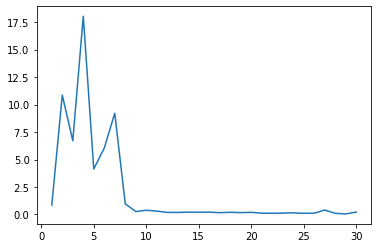

In [22]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1,output2,label) #criteria here is contrastive loss
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0:
          print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
          iteration_number +=1
          counter.append(iteration_number)
          loss_history.append(loss_contrastive.item())
            
show_plot(counter,loss_history)

###**TEST**

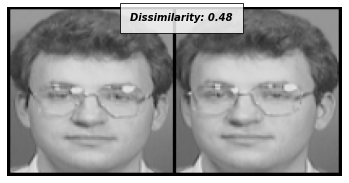

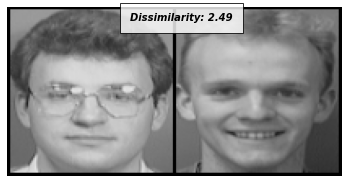

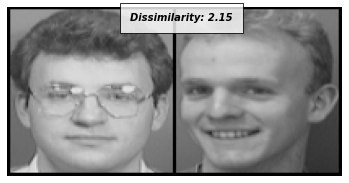

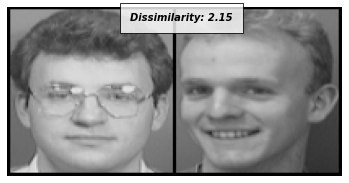

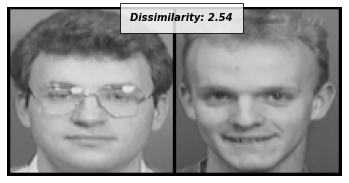

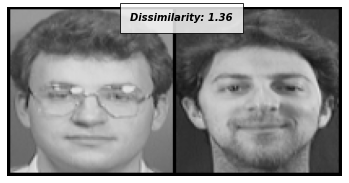

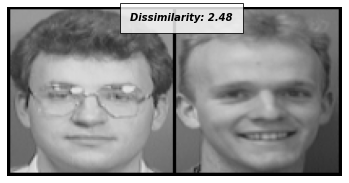

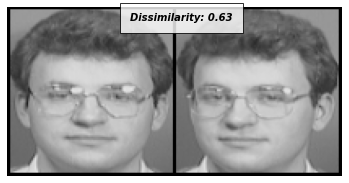

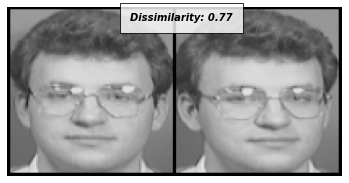

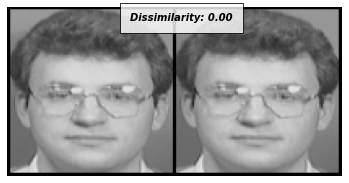

In [23]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    #print(class_list)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())

    euclidean_distance = F.pairwise_distance(output1, output2)

    concatenated = torch.cat((x0,x1),0)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



###**SAVE MODEL**

In [24]:
net.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=128, bias=True)
  )
)

In [25]:
torch.save(net.state_dict(),'./models/siam_net_new.pth') # saving the model

#**EXTRACT FEATURE REPRESENTATION**

Extract feature representations of test and train data and save it in csv file

In [26]:
output = [] # to store feature
classes = [] # to store classnames

In [27]:
def get_feature(data, folder):
  for i in range(len(data)):
    sample = next(iter(data))
    img = sample[0]
    img = img.cuda()

    out = net.representations(Variable(img))  

    output.append(out.data.cpu().numpy())
    classes.append(sample[1].data.cpu().numpy()[0])

###**FEATURE REPRESENTAION OF TRAIN DATA**

In [28]:
# get train data
f_data_train = dset.ImageFolder(root=Config.training_dir,
                                transform=transforms.Compose([transforms.Resize((100,100)),
                                                              transforms.Grayscale(num_output_channels=1),
                                                              transforms.ToTensor()
                                                                      ])) 

train = DataLoader(f_data_train,num_workers=6,batch_size=1,shuffle=True)


In [29]:
f_data_train.class_to_idx

{'Anuhya': 0,
 'aish': 1,
 's1': 2,
 's10': 3,
 's11': 4,
 's12': 5,
 's13': 6,
 's14': 7,
 's15': 8,
 's16': 9,
 's17': 10,
 's18': 11,
 's19': 12,
 's2': 13,
 's20': 14,
 's21': 15,
 's22': 16,
 's23': 17,
 's24': 18,
 's25': 19,
 's26': 20,
 's27': 21,
 's28': 22,
 's29': 23,
 's3': 24,
 's30': 25,
 's31': 26,
 's32': 27,
 's33': 28,
 's34': 29,
 's35': 30,
 's36': 31,
 's37': 32,
 's38': 33,
 's39': 34,
 's4': 35,
 's40': 36,
 's8': 37,
 's9': 38,
 'samreen': 39,
 'vijj': 40}

In [30]:
columns = list(f_data_train.class_to_idx.keys())
print(columns)

['Anuhya', 'aish', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's8', 's9', 'samreen', 'vijj']


In [31]:
labels = list(f_data_train.class_to_idx.values())
print(labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [32]:
import pandas as pd
label_to_col = pd.DataFrame(columns)
label_to_col

,0
0,Anuhya
1,aish
2,s1
3,s10
4,s11
5,s12
6,s13
7,s14
8,s15
9,s16


In [33]:
label_to_col.to_csv('./data/labe_to_col.csv')

In [34]:
len(train)

409

In [35]:
get_feature(train,f_data_train)

In [36]:
len(output)

409

In [37]:
len(output[0])

1

In [38]:
len(output[0][0])

128

In [39]:
print(classes)

[5, 28, 14, 10, 10, 24, 23, 5, 23, 5, 24, 27, 18, 23, 17, 14, 29, 32, 13, 22, 30, 12, 28, 36, 13, 7, 10, 11, 35, 7, 33, 36, 33, 30, 21, 15, 40, 1, 10, 6, 19, 0, 21, 10, 31, 5, 0, 36, 4, 26, 15, 3, 7, 12, 4, 34, 34, 38, 14, 5, 40, 11, 28, 25, 12, 34, 26, 33, 39, 3, 8, 0, 11, 17, 6, 25, 11, 37, 4, 36, 30, 11, 25, 39, 28, 1, 29, 27, 26, 26, 15, 1, 15, 8, 18, 26, 3, 8, 15, 12, 6, 21, 32, 1, 40, 8, 24, 2, 5, 21, 14, 4, 10, 22, 29, 0, 21, 21, 26, 18, 1, 13, 11, 31, 31, 0, 4, 17, 10, 10, 17, 12, 20, 27, 10, 6, 21, 8, 20, 20, 10, 31, 34, 8, 31, 32, 33, 34, 22, 9, 25, 21, 32, 22, 2, 19, 1, 1, 19, 31, 21, 35, 16, 22, 39, 6, 18, 22, 32, 2, 2, 16, 32, 2, 2, 5, 17, 33, 11, 31, 40, 5, 30, 21, 23, 15, 5, 4, 6, 27, 32, 33, 23, 38, 36, 37, 20, 14, 22, 33, 31, 10, 6, 13, 25, 12, 11, 10, 25, 34, 15, 28, 4, 34, 8, 23, 36, 34, 12, 12, 18, 11, 32, 38, 2, 21, 4, 32, 17, 9, 10, 9, 28, 40, 5, 14, 20, 35, 9, 34, 6, 33, 21, 22, 21, 38, 22, 2, 28, 24, 24, 26, 3, 28, 39, 20, 34, 35, 4, 10, 38, 6, 7, 18, 30, 0, 35,

In [40]:
len(classes)

409

In [41]:
output[0][0] 

array([-3.26815546e-01, -3.94707583e-02, -1.79834783e-01, -4.51278202e-02,
        1.96806282e-01,  3.68797928e-01, -2.34481767e-01, -2.61916578e-01,
       -1.93890721e-01,  2.96834677e-01,  1.79571405e-01, -1.53404742e-01,
       -3.25490594e-01, -1.84558719e-01,  2.87120551e-01, -9.15785730e-02,
       -1.89024612e-01, -9.72778350e-02, -1.58414673e-02, -1.75255209e-01,
       -1.40219733e-01, -5.77994473e-02,  8.66584629e-02, -1.14953235e-01,
       -2.21087448e-02,  1.69870108e-01, -8.02597702e-02,  4.61296231e-01,
       -5.55459112e-02, -2.70495981e-01,  4.77025881e-02,  1.56502619e-01,
        1.78349882e-01, -2.16143839e-02,  9.15211365e-02,  1.60634428e-01,
       -3.60265732e-01, -1.04875617e-01, -2.44468361e-01, -5.25848754e-02,
       -8.35101604e-02,  1.47306584e-02, -1.50006145e-01,  2.80350268e-01,
        5.87392151e-02, -3.26869898e-02, -2.54656196e-01,  2.37772837e-02,
        9.94088054e-02,  3.23396653e-01,  2.19245031e-01, -3.97519648e-01,
        2.72572726e-01,  

###**FEATURE REPRESENTAION OF TEST DATA**

In [42]:
# get test data
f_data_test = dset.ImageFolder(root=Config.testing_dir,
                               transform=transforms.Compose([transforms.Resize((100,100)),
                                                              transforms.Grayscale(num_output_channels=1),
                                                              transforms.ToTensor()
                                                                      ]))
test = DataLoader(f_data_test,num_workers=6,batch_size=1,shuffle=True) 

In [43]:
len(test)

30

In [44]:
get_feature(test,f_data_test)

In [45]:
len(output)

439

In [46]:
len(classes)

439

###**GET FINAL OUTPUT**

In [47]:
# getting the 128 features of each image into final_output
final_output = []
for i in range(len(output)):
  final_output.append(output[i][0])

In [48]:
print(final_output[0])

[-3.26815546e-01 -3.94707583e-02 -1.79834783e-01 -4.51278202e-02
  1.96806282e-01  3.68797928e-01 -2.34481767e-01 -2.61916578e-01
 -1.93890721e-01  2.96834677e-01  1.79571405e-01 -1.53404742e-01
 -3.25490594e-01 -1.84558719e-01  2.87120551e-01 -9.15785730e-02
 -1.89024612e-01 -9.72778350e-02 -1.58414673e-02 -1.75255209e-01
 -1.40219733e-01 -5.77994473e-02  8.66584629e-02 -1.14953235e-01
 -2.21087448e-02  1.69870108e-01 -8.02597702e-02  4.61296231e-01
 -5.55459112e-02 -2.70495981e-01  4.77025881e-02  1.56502619e-01
  1.78349882e-01 -2.16143839e-02  9.15211365e-02  1.60634428e-01
 -3.60265732e-01 -1.04875617e-01 -2.44468361e-01 -5.25848754e-02
 -8.35101604e-02  1.47306584e-02 -1.50006145e-01  2.80350268e-01
  5.87392151e-02 -3.26869898e-02 -2.54656196e-01  2.37772837e-02
  9.94088054e-02  3.23396653e-01  2.19245031e-01 -3.97519648e-01
  2.72572726e-01  9.47084278e-02  1.52676880e-01  1.28924370e-01
 -1.91780925e-03 -5.15233725e-02 -1.64267376e-01  3.38603228e-01
  2.19986171e-01 -2.83549

###**SAVING FEATURES AND CLASSES INTO CSV**

In [49]:
import pandas as pd

In [50]:
df = pd.DataFrame(final_output)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.326816,-0.039471,-0.179835,-0.045128,0.196806,0.368798,-0.234482,-0.261917,-0.193891,0.296835,0.179571,-0.153405,-0.325491,-0.184559,0.287121,-0.091579,-0.189025,-0.097278,-0.015841,-0.175255,-0.140220,-0.057799,0.086658,-0.114953,-0.022109,0.169870,-0.080260,0.461296,-0.055546,-0.270496,0.047703,0.156503,0.178350,-0.021614,0.091521,0.160634,-0.360266,-0.104876,-0.244468,-0.052585,...,0.394804,0.305866,0.234594,0.434673,0.208605,-0.212217,-0.361196,-0.164288,0.160560,0.177810,-0.238905,-0.048521,0.207159,0.184708,0.086928,0.256842,0.005849,0.199754,-0.366036,0.002600,0.146517,0.041739,-0.043616,0.026060,0.095749,0.227805,-0.046946,-0.142023,-0.194343,0.101818,0.445657,0.301925,0.159529,0.291902,0.248578,-0.004684,-0.034340,0.245562,-0.450753,0.066609
1,-0.032950,0.024443,-0.024735,-0.005347,0.023203,0.029368,-0.036880,0.003724,-0.033456,-0.001689,0.033837,0.006707,-0.035920,-0.015969,-0.015311,-0.040332,0.025036,0.012979,-0.034431,0.005117,-0.039354,-0.007293,-0.035711,-0.038638,0.042015,-0.024719,0.038547,0.043017,-0.011683,0.026946,-0.028398,0.037480,0.010206,-0.007139,-0.032653,0.019387,0.011764,-0.021246,0.030755,-0.028698,...,0.044149,-0.025523,0.003028,0.025911,0.016689,0.017153,0.019572,-0.043618,-0.003698,0.001796,0.003185,0.015757,-0.003002,0.022304,0.007187,0.035696,-0.022789,0.042793,0.039867,-0.024044,0.024489,-0.006569,0.020906,0.022730,-0.000003,-0.039032,-0.044540,-0.033879,-0.033554,-0.035247,-0.017857,-0.023281,-0.034829,0.013815,-0.010894,0.004834,-0.017566,0.032597,-0.011418,0.026046
2,-0.028311,0.155138,0.030207,-0.035133,-0.050182,0.121693,0.160800,-0.084720,0.144697,-0.194589,0.232524,0.035208,0.020036,-0.127965,-0.094713,0.143538,-0.084119,-0.016981,0.089094,-0.216945,-0.127407,0.151457,-0.120878,-0.178232,0.141846,-0.062144,0.084830,-0.067203,-0.103359,-0.034191,-0.092769,0.023635,-0.040222,0.117344,-0.114475,0.137306,-0.186204,-0.097574,0.017694,-0.158014,...,-0.128706,-0.062319,0.109328,0.008959,-0.128875,0.102520,-0.101417,-0.083639,-0.015926,0.077056,0.063580,0.010671,0.055534,-0.102738,-0.016778,0.120706,-0.182778,-0.027547,-0.094186,0.083018,-0.171041,-0.097624,0.171537,0.004281,0.059722,0.097968,0.035592,-0.107002,-0.136735,0.042007,0.080968,-0.066173,0.216125,-0.017004,0.113391,-0.170689,0.142533,-0.142129,-0.075161,-0.020768
3,-0.000339,0.125269,0.017118,-0.064045,0.014930,0.049215,0.053014,-0.048828,0.048245,-0.080148,0.165759,0.020953,-0.011452,-0.047996,-0.002541,0.059747,-0.003530,-0.030905,-0.004410,-0.075421,-0.025522,0.060394,-0.086479,-0.078845,0.041606,-0.050778,0.028154,-0.042972,-0.059067,0.030158,-0.076846,-0.008223,-0.035801,0.035919,-0.072252,0.081104,-0.031179,-0.069438,-0.018069,-0.031063,...,-0.013201,-0.015073,0.039700,0.033037,-0.047260,0.048221,-0.066775,-0.062203,-0.019151,0.001126,0.026361,0.033512,-0.020636,-0.078262,0.018695,0.048355,-0.115414,0.008148,-0.023435,0.045609,-0.106079,-0.103297,0.082114,0.011479,0.035016,0.020548,0.019101,-0.071464,-0.064104,0.027732,-0.018175,-0.063155,0.074827,-0.024341,0.062340,-0.106386,0.076370,-0.042407,-0.050556,-0.005391
4,-0.032950,0.024443,-0.024735,-0.005347,0.023203,0.029368,-0.036880,0.003724,-0.033456,-0.001689,0.033837,0.006707,-0.035920,-0.015969,-0.015311,-0.040332,0.025036,0.012979,-0.034431,0.005117,-0.039354,-0.007293,-0.035711,-0.038638,0.042015,-0.024719,0.038547,0.043017,-0.011683,0.026946,-0.028398,0.037480,0.010206,-0.007139,-0.032653,0.019387,0.011764,-0.021246,0.030755,-0.028698,...,0.044149,-0.025523,0.003028,0.025911,0.016689,0.017153,0.019572,-0.043618,-0.003698,0.001796,0.003185,0.015757,-0.003002,0.022304,0.007187,0.035696,-0.022789,0.042793,0.039867,-0.024044,0.024489,-0.006569,0.020906,0.022730,-0.000003,-0.039032,-0.044540,-0.033879,-0.033554,-

In [51]:
df['label'] = classes # add label column

In [52]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,label
0,-0.326816,-0.039471,-0.179835,-0.045128,0.196806,0.368798,-0.234482,-0.261917,-0.193891,0.296835,0.179571,-0.153405,-0.325491,-0.184559,0.287121,-0.091579,-0.189025,-0.097278,-0.015841,-0.175255,-0.140220,-0.057799,0.086658,-0.114953,-0.022109,0.169870,-0.080260,0.461296,-0.055546,-0.270496,0.047703,0.156503,0.178350,-0.021614,0.091521,0.160634,-0.360266,-0.104876,-0.244468,-0.052585,...,0.305866,0.234594,0.434673,0.208605,-0.212217,-0.361196,-0.164288,0.160560,0.177810,-0.238905,-0.048521,0.207159,0.184708,0.086928,0.256842,0.005849,0.199754,-0.366036,0.002600,0.146517,0.041739,-0.043616,0.026060,0.095749,0.227805,-0.046946,-0.142023,-0.194343,0.101818,0.445657,0.301925,0.159529,0.291902,0.248578,-0.004684,-0.034340,0.245562,-0.450753,0.066609,5
1,-0.032950,0.024443,-0.024735,-0.005347,0.023203,0.029368,-0.036880,0.003724,-0.033456,-0.001689,0.033837,0.006707,-0.035920,-0.015969,-0.015311,-0.040332,0.025036,0.012979,-0.034431,0.005117,-0.039354,-0.007293,-0.035711,-0.038638,0.042015,-0.024719,0.038547,0.043017,-0.011683,0.026946,-0.028398,0.037480,0.010206,-0.007139,-0.032653,0.019387,0.011764,-0.021246,0.030755,-0.028698,...,-0.025523,0.003028,0.025911,0.016689,0.017153,0.019572,-0.043618,-0.003698,0.001796,0.003185,0.015757,-0.003002,0.022304,0.007187,0.035696,-0.022789,0.042793,0.039867,-0.024044,0.024489,-0.006569,0.020906,0.022730,-0.000003,-0.039032,-0.044540,-0.033879,-0.033554,-0.035247,-0.017857,-0.023281,-0.034829,0.013815,-0.010894,0.004834,-0.017566,0.032597,-0.011418,0.026046,28
2,-0.028311,0.155138,0.030207,-0.035133,-0.050182,0.121693,0.160800,-0.084720,0.144697,-0.194589,0.232524,0.035208,0.020036,-0.127965,-0.094713,0.143538,-0.084119,-0.016981,0.089094,-0.216945,-0.127407,0.151457,-0.120878,-0.178232,0.141846,-0.062144,0.084830,-0.067203,-0.103359,-0.034191,-0.092769,0.023635,-0.040222,0.117344,-0.114475,0.137306,-0.186204,-0.097574,0.017694,-0.158014,...,-0.062319,0.109328,0.008959,-0.128875,0.102520,-0.101417,-0.083639,-0.015926,0.077056,0.063580,0.010671,0.055534,-0.102738,-0.016778,0.120706,-0.182778,-0.027547,-0.094186,0.083018,-0.171041,-0.097624,0.171537,0.004281,0.059722,0.097968,0.035592,-0.107002,-0.136735,0.042007,0.080968,-0.066173,0.216125,-0.017004,0.113391,-0.170689,0.142533,-0.142129,-0.075161,-0.020768,14
3,-0.000339,0.125269,0.017118,-0.064045,0.014930,0.049215,0.053014,-0.048828,0.048245,-0.080148,0.165759,0.020953,-0.011452,-0.047996,-0.002541,0.059747,-0.003530,-0.030905,-0.004410,-0.075421,-0.025522,0.060394,-0.086479,-0.078845,0.041606,-0.050778,0.028154,-0.042972,-0.059067,0.030158,-0.076846,-0.008223,-0.035801,0.035919,-0.072252,0.081104,-0.031179,-0.069438,-0.018069,-0.031063,...,-0.015073,0.039700,0.033037,-0.047260,0.048221,-0.066775,-0.062203,-0.019151,0.001126,0.026361,0.033512,-0.020636,-0.078262,0.018695,0.048355,-0.115414,0.008148,-0.023435,0.045609,-0.106079,-0.103297,0.082114,0.011479,0.035016,0.020548,0.019101,-0.071464,-0.064104,0.027732,-0.018175,-0.063155,0.074827,-0.024341,0.062340,-0.106386,0.076370,-0.042407,-0.050556,-0.005391,10
4,-0.032950,0.024443,-0.024735,-0.005347,0.023203,0.029368,-0.036880,0.003724,-0.033456,-0.001689,0.033837,0.006707,-0.035920,-0.015969,-0.015311,-0.040332,0.025036,0.012979,-0.034431,0.005117,-0.039354,-0.007293,-0.035711,-0.038638,0.042015,-0.024719,0.038547,0.043017,-0.011683,0.026946,-0.028398,0.037480,0.010206,-0.007139,-0.032653,0.019387,0.011764,-0.021246,0.030755,-0.028698,...,-0.025523,0.003028,0.025911,0.016689,0.017153,0.019572,-0.043618,-0.003698,0.001796,0.003185,0.015757,-0.003002,0.022304,0.007187,0.035696,-0.022789,0.042793,0.039867,-0.024044,0.024489,-0.006569,0.020906,0.022730,-0.000003,-0.039032,-0.044540,-0.033879,-0.033554,-0.035247,-0.017857,-0.023281,-0.0

In [53]:
df.to_csv("./data/task2/features2_new.csv") # save data to csv file



https://discuss.pytorch.org/t/save-the-output-matrix-of-every-layer-of-autoencoder/20131/4